In [227]:
%pylab inline
from __future__ import division
import scipy as sp
from scipy import stats
from scipy.signal import argrelextrema
from scipy.interpolate import interp1d
# import csv
from decimal import *
import pickle
import mpld3
mpld3.enable_notebook()

Populating the interactive namespace from numpy and matplotlib


In [3]:
import operator as op
def nCr(n, r):
    r = min(r, n-r)
    if r == 0: return 1
    numer = reduce(op.mul, xrange(n, n-r, -1))
    denom = reduce(op.mul, xrange(1, r+1))
    return numer//denom


In [4]:
def Q(x):
    return 0.5*sp.special.erfc(x/sqrt(2))

def Qinv(x):
    return (sqrt(2)*sp.special.erfinv(1-2*x))**2

In [367]:
# For scipy Linear Interpolation
# rate = num_nodes * 160 / 10,000
def hs_rs_table(op_SNR, rate, blocklength):
    rate = rate * 7/4
    k = (1-rate)*blocklength
    msg = rate*blocklength
#     op_SNR = arange(-5, 10, 0.01)
    pbitdrop = Q(sqrt(2*10**(op_SNR/10)))
#     pbitdrop = array([0.5*math.erfc(sqrt(10**(opsnr/10)/2)) for opsnr in op_SNR])
    hcerr = 1 - ((1-pbitdrop)**7 + 7*pbitdrop*(1-pbitdrop)**6)
    hcflst = 1 - (1-hcerr)**3
    reeddrop = [sum([nCr(blocklength, d)* hcf**d *(1-hcf)**(blocklength-d) for d in range(int(k/2)+1, blocklength)]) \
                for hcf in hcflst]
#     func = interp1d(op_SNR, reeddrop, kind='linear', bounds_error=False, fill_value=(1.0, 0.0))
    return [op_SNR, array(reeddrop)]

In [6]:
def shannon_table(rate):
    op_SNR = arange(-20, 5, 0.01)
    shannon = []
    for SNR in op_SNR:
        C = log2(1 + 10**(SNR/10))
        if rate > C:
            shannon.append(1.0) # pr failure
        else:
            shannon.append(0.0)
#     shannon = 1 - exp(-(2**rate -1)/op_SNR)
    return [op_SNR, array(shannon)]

In [7]:
def hard_bin_shannon_table(rate):
    op_SNR = arange(-20, 5, 0.01)
    shannon = []
    SNR = 2*10**(op_SNR/10)
    pbit = Q(sqrt(SNR))
    for p in pbit:
        C = 1 + p*log2(p) + (1-p)*log2(1-p)
        if rate > C:
            shannon.append(1.0) # pr failure
        else:
            shannon.append(0.0)
    return [op_SNR, array(shannon)]

In [8]:
def save_table(table, filename):
    f = open(filename, 'w')
    pickle.dump(table, f)
    f.close()
    
def load_table(filename):
    f = open(filename, 'r')
    table = pickle.load(f)
    f.close()
    return table

In [84]:
def shannon_combo(N, a, rate1, p1, SNR):
#     rate2 = (N-a)/N*rate1 + 2*N/10000 # Rate adaptation
    rate2 = rate1
    p2 = 1 - exp(-(2**rate2 -1)/(10**(SNR/10)))
    return p2**a * min(p2/p1, 1)

In [157]:
def adaptive_endpoints(fx, fade):
    grad = np.gradient(fx, 10**(-3))*10**(-3) # Magic
#     grad2 = np.gradient(grad, 10**(-4))*10**(-4)
    
    ind = argrelextrema(grad, np.less)[0]
    ind = ind[np.argsort(grad[ind])]
    if len(ind) > 0:
        mid = fade[ind[0]]
        end1, end2 = mid - 5000*10**(-9), mid + 5000*10**(-9) # Magic
    else:
        mid = 0
        end1, end2 = fade[0], fade[0]+10**(-3)
    
    endpts = [end1, end2, 2]
    return endpts

In [149]:
# Adaptive
def p_single(codetable, op_SNR, endpoint, dfade):
    fadexp = sp.stats.expon()
    fade = arange(0, endpoint, 10**(-3)) # Magic
    psingle = []
#     snrlookup = codetable(op_SNR+log10(fade))
#     fadepr = fadexp.pdf(fade)
    optimize = codetable(op_SNR+10*log10(fade)) * fadexp.pdf(fade)
    plot(fade, optimize, lw=2.0)
    title('Optimize')
    endpts = adaptive_endpoints(optimize, fade)
    print('endpts', endpts)
#     print(op_SNR, endpts)
    fade = arange(0, endpts[0], dfade[0])
    fadepr = fadexp.pdf(fade)
    snrlookup = codetable(op_SNR+10*log10(fade))
    psingle.append(dfade[0]*np.dot(snrlookup, fadepr))
    print(psingle)
    for idx in range(1, len(endpts)):
        fade = arange(endpts[idx-1], endpts[idx], dfade[idx])
        snrlookup = codetable(op_SNR+10*log10(fade))
        fadepr = fadexp.pdf(fade)
        psingle.append(dfade[idx]*np.dot(snrlookup, fadepr))
        print(psingle)
    return sum(psingle)

In [47]:
def p_combo(codetable, a, op_SNR, endpoint, dfade):
    if a == 0:
        return 1.0
    fadexp = sp.stats.erlang(a)
    pcombo = []
    fade = arange(0, endpoint, 10**(-3))
    snrlookup = codetable(op_SNR+10*log10(fade))
    fadepr = fadexp.pdf(fade)
    optimize = snrlookup * fadepr
    endpts = adaptive_endpoints(optimize, fade)
    fade = arange(0, endpts[0], dfade[0])
    snrlookup = codetable(op_SNR+10*log10(fade))
    fadepr = fadexp.pdf(fade)
    pcombo.append(dfade[0]*np.dot(snrlookup, fadepr))
    for idx in range(1, len(endpts)):
        fade = arange(endpts[idx-1], endpts[idx], dfade[idx])
        snrlookup = codetable(op_SNR+10*log10(fade))
        fadepr = fadexp.pdf(fade)
        pcombo.append(dfade[idx]*np.dot(snrlookup, fadepr))
#         pcombo.append(sum([snr_lookup(codetable, kmin, kmax, op_SNR+log10(f), tabledSNR) * fadexp.pdf(f) * dfade[idx] for f in fade]))
    return sum(pcombo)

In [13]:
# N = num_nodes
def p_protocol(codetable, N, op_SNR, endpoint, dfade):
    psingle = p_single(codetable, op_SNR, endpoint, dfade)
#     print('psingle', psingle)
#     print('psingle', psingle, 'pcombo, ')
    return sum([nCr(N, a) * (1-psingle)**a * psingle**(N-a) * 
                (1-(1-p_combo(codetable, a, op_SNR, endpoint, dfade))**(N-a)) for a in range(N)])

In [14]:
def hockey(codingscheme, dSNR, dfade, endpoint, threshold, start_SNR, start_nodes, end_nodes):
    nominal_needed = []
    for N in range(start_nodes, end_nodes):
        filename = codingscheme + '/n' + str(N) + '.in'
        codetable = load_table(filename)
        func = interp1d(codetable[0], codetable[1], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))
        SNR = start_SNR-dSNR # dB scale
        pprotocol = 1.0
        while pprotocol > threshold:
            SNR += dSNR
            pprotocol = p_protocol(func, N, SNR, end, dfade)
        print('P(protocol)', N, SNR, pprotocol)
        nominal_needed.append(SNR)

    plot(range(start_nodes, end_nodes), array(nominal_needed), lw=2.0, label=codingscheme)
    xlabel('Number of Nodes', fontsize=18)
    ylabel('Nominal SNR Needed (dB)', fontsize=18, labelpad=20)
    title('Hockey {0}'.format(threshold), fontsize=24)
    
    return array(nominal_needed)

ERROR! Session/line number was not unique in database. History logging moved to new session 262
[ 1.  0.  0. ...,  0.  0.  0.]

/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:27: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:35: RuntimeWarning: divide by zero encountered in log10



('endpts', [0.0, 0.001, 2])
6.6e-09
CPU times: user 1.16 s, sys: 535 ms, total: 1.7 s
Wall time: 1.78 s


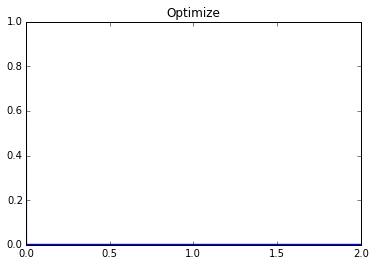

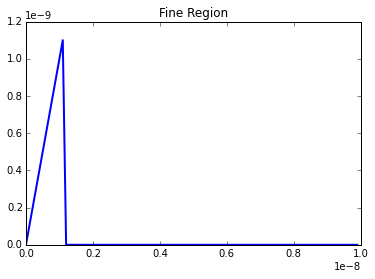

In [49]:
%%time

N = 1
threshold = 10**(-9)
endpoint = 2
dfade = [10**(-3), 10**(-10), 10**(-3)]
dSNR = 0.1
codingscheme = 'shannon_tables'
filename = codingscheme + '/n' + str(N) + '.in'
table = load_table(filename)
codetable = interp1d(table[0], table[1], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))
start_nodes, end_nodes = 1, 35
start_SNR = -2

a = 2

# test = []
op_SNR = 70
# z = p_single(func, op_SNR, endpoint, dfade)
# z = p_combo(func, a, op_SNR, endpoint, dfade)
# print(z)

fadexp = sp.stats.expon()
fade = arange(0, endpoint, 10**(-3)) # Magic
psingle = []
#     snrlookup = codetable(op_SNR+log10(fade))
#     fadepr = fadexp.pdf(fade)
optimize = codetable(op_SNR+10*log10(fade)) * fadexp.pdf(fade)
plot(fade, optimize, lw=2.0)
title('Optimize')
print(optimize)
endpts = adaptive_endpoints(optimize, fade)
print('endpts', endpts)

fade = arange(0, 0.001, 10**(-10))
snrlookup = codetable(op_SNR+10*log10(fade))
fadepr = fadexp.pdf(fade)
print(np.dot(snrlookup, fade))
test = snrlookup*fade
# print('test', test)
figure()
# plot(fade, test, lw=2.0)
plot(fade[:100], test[:100], lw=2.0)
title('Fine Region')

# Loudest Talker

In [50]:
def padd(pcrit, k, rsblock, numwords):
    hcerr = 1 - ((1-pcrit)**7 + 7*pcrit*(1-pcrit)**6)
    hccrit = 1 - (1-hcerr)**numwords
    paddnoise = sum([nCr(rsblock, d)* hccrit**d *(1-hccrit)**(rsblock-d) for d in range(int(k/2)+1, rsblock)])

('Shannon', array([ 70.474,  30.894,  18.625,  12.713,   9.293,   7.106,   5.614,
         4.549,   3.763,   3.168,   2.709,   2.351,   2.068,   1.842,
         1.662,   1.518,   1.404,   1.312,   1.241,   1.185,   1.144,
         1.113,   1.093,   1.081,   1.076,   1.078,   1.085,   1.097,
         1.112,   1.132,   1.155,   1.18 ,   1.208,   1.238]))
CPU times: user 28 s, sys: 326 ms, total: 28.4 s
Wall time: 30.6 s


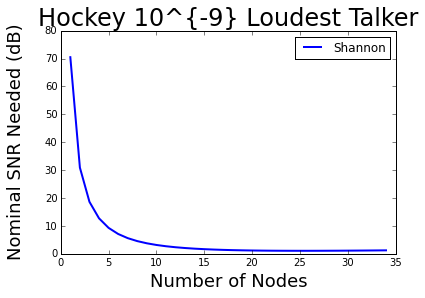

In [273]:
%%time
numwords = 3 # number of hamming code blocks stuck together
bpw = 21 # bits per word

target = 10**(-9)
msgsize = 160
blocklength = 10000
rsblock = int(blocklength/bpw)
dSNR = 0.001
dfade = 10**(-2)
# dfade = [10**(-3), 10**(-10), 10**(-3)]
end = 2
paddratio = 0.05

nomSNR = []
occupy = []
# hcritical = []

fadexp = sp.stats.expon()
# actual = []

for N in range(1, 35):
#     filename = 'lookup_0-01/n' + str(N) + '.in'
#     codetable = load_table(filename)
#     func = interp1d(codetable[0], codetable[1], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))
    # Doing Shannon first -- should match Occupy CoW
    padd = 0
    
    rate = N * 160 / 10000
#     k = (1-rate)*rsblock
    
    SNR = -5
    pprotocol = 1.0
    while pprotocol > target:
        SNR += dSNR
        linSNR = 10**(SNR/10)
        hcrit = (2**rate - 1)/linSNR
        pbadfade = 1 - exp(-hcrit)
        psingle = pbadfade + (1-pbadfade)*padd
#         print(psingle)
        
#         for fade in range(0, 1, 0.01):
#             snr_gain = -10*log10(-log(1 - pfade))
#             pcrit = Q((2*10**((SNR + 10*log10(fade))/10))**0.5) # highest bit drop tolerable
#             paddnoise = padd(pcrit, k, rsblock, numwords)
        pprotocol = sum([nCr(N, a) * (1-psingle)**a * psingle**(N-a) * (1-(1-(pbadfade**a + (1-pbadfade**a) * padd))**(N-a)) for a in range(N)])
    nomSNR.append(SNR)
#     hcritical.append(hcrit)
    
#     SNR = -5 # dB scale
#     pshannon = 1.0
#     while pshannon > threshold:
#         plink = 1 - exp(-(2**rate -1)/(10**(SNR/10)))
#         pshannon = sum([nCr(N, a) * (1-plink)**a * plink**(N-a) * 
#                          (1-(1-shannon_combo(N, a, rate, plink, SNR))**(N-a)) for a in range(N)])
#         SNR += dSNR
#     occupy.append(SNR-dSNR)
    
print('Shannon', array(nomSNR))
# print('HCritical', hcritical)
# print('Occupy CoW', array(shannon))
plot(range(1, 35), nomSNR, lw=2.0, label='Shannon')
# plot(range(1, 35), shannon, lw=2.0, label='Occupy CoW')
legend(loc=0)
xlabel('Number of Nodes', fontsize=18)
ylabel('Nominal SNR Needed (dB)', fontsize=18, labelpad=20)
title('Hockey 10^{-9} Loudest Talker', fontsize=24)
savefig('LoudestTalkerShannon.pdf', bbox='tight')

/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log10


('Protocol', 30, 54.90000000000051, 9.5582759269012599e-10)
('Protocol', 31, 55.200000000000514, 9.5885721234034533e-10)
('Protocol', 32, 55.50000000000052, 9.7770865948652345e-10)
('Protocol', 33, 55.900000000000524, 9.5579031452177331e-10)
('Protocol', 34, 56.30000000000053, 9.9921584056245083e-10)
('Leah', array([ 54.9,  55.2,  55.5,  55.9,  56.3]))
CPU times: user 21min 14s, sys: 5min 36s, total: 26min 51s
Wall time: 28min 17s


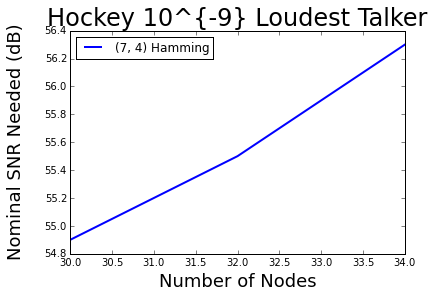

In [126]:
%%time
numwords = 3 # number of hamming code blocks stuck together
bpw = 21 # bits per word

target = 10**(-9)
msgsize = 160
blocklength = 10000
rsblock = int(blocklength/bpw)
dSNR = 0.1
# dfade = 10**(-6)
dfade = [10**(-3), 10**(-10), 10**(-3)]
end = 2
paddratio = 0.05

hamming = []

fadexp = sp.stats.expon()

for N in range(30, 35):
    filename = 'lookup_0-01/n' + str(N) + '.in'
    codetable = load_table(filename)
    func = interp1d(codetable[0], codetable[1], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))
    
    rate = N * 160 / 10000
    
    SNR = 0
    pprotocol = 1.0
    while pprotocol > target:
        SNR += dSNR
        linSNR = 10**(SNR/10)
        hcrit = (2**rate - 1)/linSNR
        pbadfade = 1 - exp(-hcrit)
        
#         fade = arange(hcrit, end, dfade)
#         padd = np.dot(func(SNR+10*log10(fade)), fadexp.pdf(fade)) * dfade
        padd = p_single(func, SNR, end, dfade)
        
        psingle = pbadfade + (1-pbadfade)*padd
        
#         for fade in range(0, 1, 0.01):
#             snr_gain = -10*log10(-log(1 - pfade))
#             pcrit = Q((2*10**((SNR + 10*log10(fade))/10))**0.5) # highest bit drop tolerable
#             paddnoise = padd(pcrit, k, rsblock, numwords)
        pprotocol = sum([nCr(N, a) * (1-psingle)**a * psingle**(N-a) * (1-(1-(pbadfade**a + (1-pbadfade**a) * padd))**(N-a)) for a in range(N)])
    hamming.append(SNR)
    print('Protocol', N, SNR, pprotocol)
    
    
print('Leah', array(hamming))
# print('Occupy CoW', array(shannon))
plot(range(30, 35), array(hamming), lw=2.0, label='(7, 4) Hamming')
# plot(range(1, 35), shannon, lw=2.0, label='Occupy CoW')
legend(loc=0)
xlabel('Number of Nodes', fontsize=18)
ylabel('Nominal SNR Needed (dB)', fontsize=18, labelpad=20)
title('Hockey 10^{-9} Loudest Talker', fontsize=24)
# savefig('LoudestTalkerShannon.pdf', bbox='tight')

('hcrit', 3.9474366635040536e-08, -74.03684829504941)
('badfade', 3.9474365887137708e-08)
[ -4.0368483   50.00001714  53.01030853  54.77121826  56.0206042
  56.98970347  57.78151536  58.45098285  59.03090201  59.542427
  60.00000171  60.41392841  60.79181389  61.13943484  61.46128158
  61.76091373  62.0412009   62.30449022  62.552726    62.78753691
  63.01030081  63.22219376  63.42422759  63.61727911  63.80211313
  63.97940077  64.14973414  64.31363828  64.47158093  64.62398057
  64.77121312  64.91361749  65.05150032  65.18513992  65.31478967
  65.44068093  65.56302548  65.6820177   65.79783642  65.91064651
  66.02060034  66.12783899  66.23249331  66.33468495  66.43452715
  66.53212552  66.62757869  66.72097894  66.81241273  66.90196115
  66.98970039  67.0757021   67.16003377  67.24275902  67.32393792
  67.40362721  67.48188058  67.55874886  67.63428023  67.70852041
  67.78151279  67.85329863  67.92391717  67.99340577  68.06180001
  68.12913383  68.19543962  68.26074828  68.32508938  6

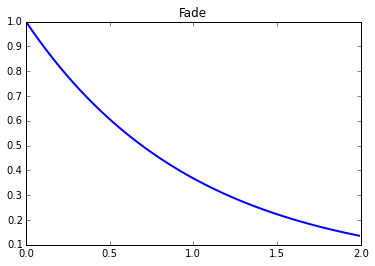

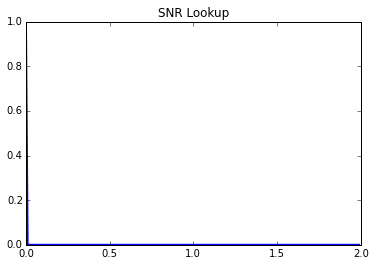

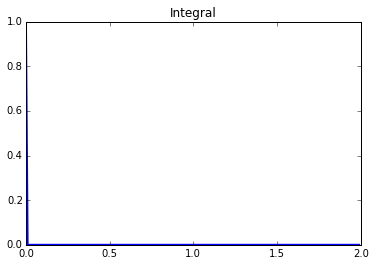

In [113]:
N = 30
rate = N*160/10000
SNR = 70
linSNR = 10**(SNR/10)
hcrit = (2**rate - 1)/linSNR
pbadfade = 1 - exp(-hcrit)
print('hcrit', hcrit, 10*log10(hcrit))
print('badfade', pbadfade)
fade = arange(hcrit, end, dfade)
padd = np.dot(func(SNR+10*log10(fade)), fadexp.pdf(fade)) * dfade
plot(fade, fadexp.pdf(fade), lw=2.0)
title('Fade')
figure()
plot(fade, func(SNR+10*log10(fade)), lw=2.0)
title('SNR Lookup')
print(SNR+10*log10(fade))
figure()
plot(fade, func(SNR+10*log10(fade)) * fadexp.pdf(fade), lw=2.0)
title('Integral')
print('p_additive', padd)

psingle = pbadfade + (1-pbadfade)*padd
print('p_single', psingle)
pprotocol = sum([nCr(N, a) * (1-psingle)**a * psingle**(N-a) * (1-(1-(pbadfade**a + (1-pbadfade**a) * padd))**(N-a)) for a in range(N)])
print('protocol', pprotocol)
# print(fade)

('hcrit', 0.03947436663504054, -14.036848295049406)
('badfade', 0.038705405110033397)
[ -4.0368483   -3.05619757  -2.25670174  -1.58175404  -0.99772924
  -0.48301367  -0.02288817   0.39312441   0.77274737   1.12183795
   1.44494398   1.74566722   2.02690886   2.2910402    2.54002429
   2.77550464   2.99887095   3.21130886   3.41383804   3.6073418
   3.79259033   3.97025929   4.14094461   4.3051746    4.46341981
   4.61610112   4.76359655   4.90624683   5.04436018   5.17821632
   5.30806987   5.43415326   5.55667927   5.67584313   5.79182445
   5.9047888    6.01488917   6.1222672    6.22705427   6.32937248
   6.42933549   6.52704929   6.62261288   6.71611885   6.80765394
   6.89729953   6.98513205   7.07122338   7.15564122   7.2384494
   7.31970814   7.39947437   7.47780193   7.5547418    7.63034229
   7.70464924   7.77770618   7.84955445   7.9202334    7.9897805
   8.0582314    8.12562015   8.19197919   8.25733953   8.32173077
   8.38518125   8.44771804   8.50936709   8.57015326   8.63

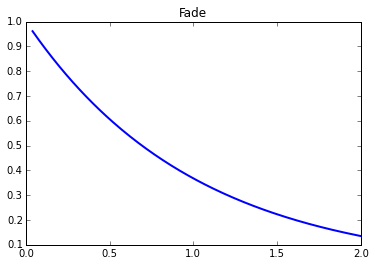

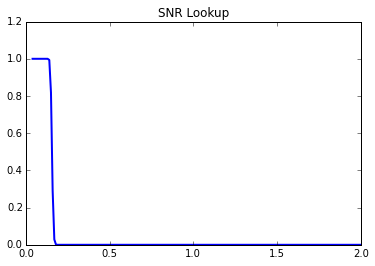

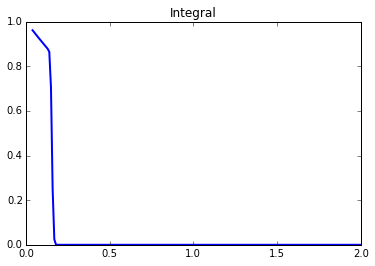

In [114]:
N = 30
rate = N*160/10000
SNR = 10
linSNR = 10**(SNR/10)
hcrit = (2**rate - 1)/linSNR
pbadfade = 1 - exp(-hcrit)
print('hcrit', hcrit, 10*log10(hcrit))
print('badfade', pbadfade)
fade = arange(hcrit, end, dfade)
padd = np.dot(func(SNR+10*log10(fade)), fadexp.pdf(fade)) * dfade
# print('Vasuki', fadexp.pdf(fade))
plot(fade, fadexp.pdf(fade), lw=2.0)
title('Fade')
figure()
plot(fade, func(SNR+10*log10(fade)), lw=2.0)
title('SNR Lookup')
print(SNR+10*log10(fade))
figure()
plot(fade, func(SNR+10*log10(fade)) * fadexp.pdf(fade), lw=2.0)
title('Integral')
print('p_additive', padd)

psingle = pbadfade + (1-pbadfade)*padd
print('p_single', psingle)
pprotocol = sum([nCr(N, a) * (1-psingle)**a * psingle**(N-a) * (1-(1-(pbadfade**a + (1-pbadfade**a) * padd))**(N-a)) for a in range(N)])
print('protocol', pprotocol)
# print(fade)

In [115]:
fade = arange(0, 2, 10**(-2))
print(10*log10(fade))

[        -inf -20.         -16.98970004 -15.22878745 -13.97940009
 -13.01029996 -12.2184875  -11.5490196  -10.96910013 -10.45757491 -10.
  -9.58607315  -9.20818754  -8.86056648  -8.53871964  -8.23908741
  -7.95880017  -7.69551079  -7.44727495  -7.21246399  -6.98970004
  -6.77780705  -6.57577319  -6.38272164  -6.19788758  -6.02059991
  -5.85026652  -5.68636236  -5.52841969  -5.37602002  -5.22878745
  -5.08638306  -4.94850022  -4.8148606   -4.68521083  -4.55931956
  -4.43697499  -4.31798276  -4.20216403  -4.08935393  -3.97940009
  -3.87216143  -3.7675071   -3.66531544  -3.56547324  -3.46787486
  -3.37242168  -3.27902142  -3.18758763  -3.0980392   -3.01029996
  -2.92429824  -2.83996656  -2.7572413   -2.6760624   -2.59637311
  -2.51811973  -2.44125144  -2.36572006  -2.29147988  -2.2184875
  -2.14670165  -2.07608311  -2.00659451  -1.93820026  -1.87086643
  -1.80456064  -1.73925197  -1.67491087  -1.61150909  -1.5490196
  -1.48741651  -1.42667504  -1.3667714   -1.3076828   -1.24938737
  -1.19

/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: divide by zero encountered in log10


('hcrit', 3.9474366635040534e-06, -54.036848295049403)
('badfade', 3.947428872441705e-06)
('endpts', [0.0, 0.001, 2])
[0.0]
[0.0, 1.5580733451831133e-05]
[0.0, 1.5580733451831133e-05, 0.0]
('p_additive', 1.5580733451831133e-05)
('p_single', 1.9528100820435757e-05)
('protocol', 9.1278639708631936e-09)


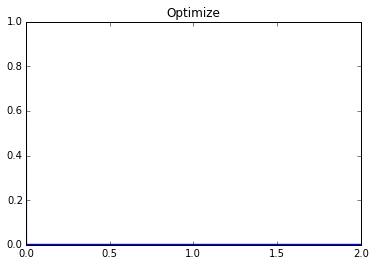

In [158]:
dfade = [10**(-4), 10**(-10), 10**(-4)]
N = 30
filename = 'lookup_0-01/n' + str(N) + '.in'
codetable = load_table(filename)
func = interp1d(codetable[0], codetable[1], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))
rate = N*160/10000
SNR = 50
linSNR = 10**(SNR/10)
hcrit = (2**rate - 1)/linSNR
pbadfade = 1 - exp(-hcrit)
print('hcrit', hcrit, 10*log10(hcrit))
print('badfade', pbadfade)
# fade = arange(hcrit, end, dfade)
padd= p_single(func, SNR, 2, dfade)
# padd = np.dot(func(SNR+10*log10(fade)), fadexp.pdf(fade)) * dfade
# plot(fade, fadexp.pdf(fade), lw=2.0)
# title('Fade')
# figure()
# plot(fade, func(SNR+10*log10(fade)), lw=2.0)
# title('SNR Lookup')
# print(SNR+10*log10(fade))
# figure()
# plot(fade, func(SNR+10*log10(fade)) * fadexp.pdf(fade), lw=2.0)
# title('Integral')
print('p_additive', padd)

psingle = pbadfade + (1-pbadfade)*padd
print('p_single', psingle)
pprotocol = sum([nCr(N, a) * (1-psingle)**a * psingle**(N-a) * (1-(1-(pbadfade**a + (1-pbadfade**a) * padd))**(N-a)) for a in range(N)])
print('protocol', pprotocol)
# print(fade)

In [168]:
SNR = 50
fade = arange(0, 10**(-3), 10**(-11))
fadepr = fadexp.pdf(fade)
snrlookup = func(SNR+10*log10(fade))
z = snrlookup*fadepr
# print(z)
# print(np.where(z==0))
# plot(fade, z, lw=2.0)
print(np.dot(snrlookup, fadepr) * 10**(-11))
# psingle.append(dfade[0]*np.dot(snrlookup, fadepr))

1.55806884519e-05


/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10


In [170]:
SNR = 50
fade = arange(0, 10**(-4), 10**(-10))
fadepr = fadexp.pdf(fade)
snrlookup = func(SNR+10*log10(fade))
z = snrlookup*fadepr
# print(z)
# print(np.where(z==0))
# plot(fade, z, lw=2.0)
print(np.dot(snrlookup, fadepr) * 10**(-10))
# psingle.append(dfade[0]*np.dot(snrlookup, fadepr))

1.55807334518e-05


/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10


# Loudest Talker Try 2

In [308]:
def loudest_talker(codingscheme, dSNR, target, paddratio, start_SNR, start_nodes, end_nodes):
    nomSNR = []

    for N in range(start_nodes, end_nodes):
        filename = codingscheme + '/n' + str(N) + '.in'
        codetable = load_table(filename)

        padd = paddratio*threshold
#         print('debug', np.where(codetable[1]<=padd))
        actualSNR = codetable[0][np.where(array(codetable[1])<=padd)[0][0]]

        SNR = start_SNR
        pprotocol = 1.0
        while pprotocol > target:
            SNR += dSNR
            hcrit = 10**((actualSNR - SNR)/10) # linear fade
            pbadfade = 1 - exp(-hcrit)
            psingle = pbadfade + (1-pbadfade)*padd

            pprotocol = sum([nCr(N, a) * (1-psingle)**a * psingle**(N-a) * 
                             (1-(1-(pbadfade**a + (1-pbadfade**a) * padd))**(N-a)) for a in range(N)])
        nomSNR.append(SNR)
        print('Loudest Speaker', N, SNR, actualSNR)

    plot(range(start_nodes, end_nodes), array(nomSNR), lw=2.0, label=codingscheme)
    legend(loc=0)
    xlabel('Number of Nodes', fontsize=18)
    ylabel('Nominal SNR Needed (dB)', fontsize=18, labelpad=20)
    title('Hockey 10^{-9} Loudest Talker', fontsize=24)
    
    return array(nomSNR)

('Loudest Speaker', 1, 70.93999999999939, -19.519999999999925)
('Loudest Speaker', 2, 30.90000000000203, -16.489999999999451)
('Loudest Speaker', 3, 18.640000000000114, -14.699999999999172)
('Loudest Speaker', 4, 12.719999999999773, -13.429999999998973)
('Loudest Speaker', 5, 9.309999999999846, -12.429999999998817)
('Loudest Speaker', 6, 7.119999999999893, -11.61999999999869)
('Loudest Speaker', 7, 5.639999999999924, -10.919999999998581)
('Loudest Speaker', 8, 4.569999999999947, -10.319999999998487)
('Loudest Speaker', 9, 3.799999999999963, -9.7799999999984024)
('Loudest Speaker', 10, 3.2099999999999755, -9.2999999999983274)
('Loudest Speaker', 11, 2.759999999999985, -8.8599999999982586)
('Loudest Speaker', 12, 2.399999999999993, -8.4599999999981961)
('Loudest Speaker', 13, 2.1199999999999988, -8.0899999999981382)
('Loudest Speaker', 14, 1.9100000000000015, -7.7399999999980835)
('Loudest Speaker', 15, 1.7300000000000013, -7.4199999999980335)
('Loudest Speaker', 16, 1.6000000000000012, 

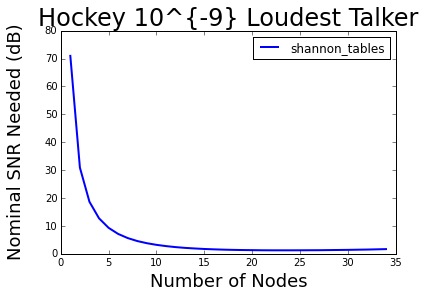

In [309]:
codingscheme = 'shannon_tables'
dSNR = 0.01
target = 10**(-9)
paddratio = 0.1 # padd = 10**(-10)
start_SNR = 0
start_nodes, end_nodes = 1, 35

shannon = loudest_talker(codingscheme, dSNR, target, paddratio, start_SNR, start_nodes, end_nodes)
print('Shannon', shannon)

('Loudest Speaker', 1, 72.9100000000004, -17.549999999999617)
('Loudest Speaker', 2, 32.890000000002026, -14.49999999999914)
('Loudest Speaker', 3, 20.630000000000425, -12.70999999999886)
('Loudest Speaker', 4, 14.72999999999973, -11.419999999998659)
('Loudest Speaker', 5, 11.319999999999803, -10.419999999998502)
('Loudest Speaker', 6, 9.14999999999985, -9.5899999999983727)
('Loudest Speaker', 7, 7.679999999999881, -8.8799999999982617)
('Loudest Speaker', 8, 6.629999999999903, -8.2599999999981648)
('Loudest Speaker', 9, 5.869999999999919, -7.7099999999980788)
('Loudest Speaker', 10, 5.289999999999932, -7.2199999999980022)
('Loudest Speaker', 11, 4.859999999999941, -6.7599999999979303)
('Loudest Speaker', 12, 4.519999999999948, -6.3399999999978647)
('Loudest Speaker', 13, 4.259999999999954, -5.9499999999978037)
('Loudest Speaker', 14, 4.059999999999958, -5.5899999999977474)
('Loudest Speaker', 15, 3.899999999999961, -5.2499999999976943)
('Loudest Speaker', 16, 3.789999999999963, -4.9199

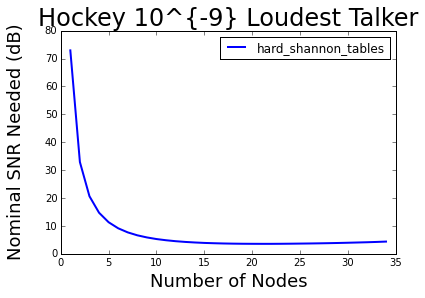

In [310]:
codingscheme = 'hard_shannon_tables'
dSNR = 0.01
target = 10**(-9)
paddratio = 0.1 # padd = 10**(-10)
start_SNR = 0
start_nodes, end_nodes = 1, 35

hardbinshannon = loudest_talker(codingscheme, dSNR, target, paddratio, start_SNR, start_nodes, end_nodes)
print('Hard Binary Shannon', hardbinshannon)

('Loudest Speaker', 1, 89.90000000000909, -0.56000000000009464)
('Loudest Speaker', 2, 46.92999999999923, -0.46000000000009678)
('Loudest Speaker', 3, 32.97000000000201, -0.37000000000009869)
('Loudest Speaker', 4, 25.880000000001246, -0.27000000000010083)
('Loudest Speaker', 5, 21.570000000000572, -0.17000000000010296)
('Loudest Speaker', 6, 18.660000000000117, -0.080000000000104876)
('Loudest Speaker', 7, 16.579999999999792, 0.019999999999892992)
('Loudest Speaker', 8, 15.019999999999724, 0.12999999999989065)
('Loudest Speaker', 9, 13.79999999999975, 0.21999999999988873)
('Loudest Speaker', 10, 12.829999999999771, 0.3199999999998866)
('Loudest Speaker', 11, 12.049999999999788, 0.42999999999988425)
('Loudest Speaker', 12, 11.379999999999802, 0.51999999999988233)
('Loudest Speaker', 13, 10.839999999999813, 0.62999999999987999)
('Loudest Speaker', 14, 10.389999999999823, 0.73999999999987764)
('Loudest Speaker', 15, 9.989999999999831, 0.83999999999987551)
('Loudest Speaker', 16, 9.669999

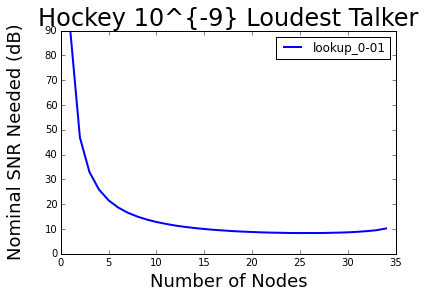

In [312]:
%%time
codingscheme = 'lookup_0-01'
dSNR = 0.01
target = 10**(-9)
paddratio = 0.1 # padd = 10**(-10)
start_SNR = 0
start_nodes, end_nodes = 1, 35

hamming = loudest_talker(codingscheme, dSNR, target, paddratio, start_SNR, start_nodes, end_nodes)
print('Hamming+RS', hamming)

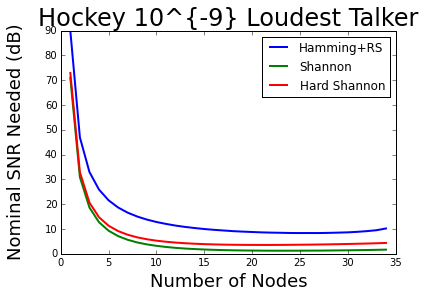

In [305]:
start_nodes, end_nodes = 1, 35
plot(range(start_nodes, end_nodes), hamming, lw=2.0, label='Hamming+RS')
plot(range(start_nodes, end_nodes), shannon, lw=2.0, label='Shannon')
plot(range(start_nodes, end_nodes), hardbinshannon, lw=2.0, label='Hard Shannon')
legend(loc=0)
xlabel('Number of Nodes', fontsize=18)
ylabel('Nominal SNR Needed (dB)', fontsize=18, labelpad=20)
title('Hockey 10^{-9} Loudest Talker', fontsize=24)
savefig('hockey_loudest.pdf', bbox='tight')

[ 18.96  16.03  14.33  13.16  12.26  11.54  10.94  10.45  10.     9.62
   9.29   8.98   8.72   8.48   8.26   8.07   7.91   7.73   7.6    7.48
   7.37   7.29   7.22   7.14   7.11   7.1    7.08   7.11   7.17   7.24
   7.39   7.62   7.91   8.53]
[ 16.99  14.04  12.34  11.15  10.25   9.51   8.9    8.39   7.93   7.54
   7.19   6.86   6.58   6.33   6.09   5.88   5.7    5.5    5.35   5.21
   5.07   4.97   4.88   4.77   4.71   4.68   4.62   4.63   4.66   4.69
   4.81   5.     5.26   5.83]


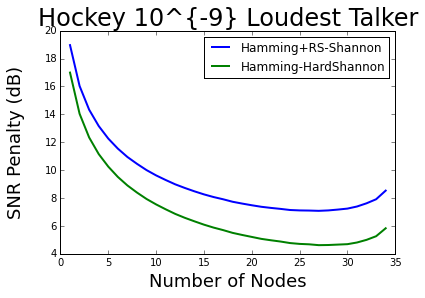

In [307]:
start_nodes, end_nodes = 1, 35
plot(range(start_nodes, end_nodes), hamming-shannon, lw=2.0, label='Hamming+RS-Shannon')
plot(range(start_nodes, end_nodes), hamming-hardbinshannon, lw=2.0, label='Hamming-HardShannon')
legend(loc=0)
xlabel('Number of Nodes', fontsize=18)
ylabel('SNR Penalty (dB)', fontsize=18, labelpad=20)
title('Hockey 10^{-9} Loudest Talker', fontsize=24)
# savefig('penalty_loudest.pdf', bbox='tight')

print(hamming-shannon)
print(hamming-hardbinshannon)

('Occupy?', array([ 70.53,  30.9 ,  18.64,  12.72,   9.31,   7.11,   5.63,   4.56,
         3.78,   3.18,   2.73,   2.37,   2.08,   1.86,   1.68,   1.54,
         1.42,   1.33,   1.26,   1.21,   1.16,   1.13,   1.12,   1.11,
         1.1 ,   1.11,   1.1 ,   1.12,   1.14,   1.16,   1.18,   1.21,
         1.24,   1.26]))
CPU times: user 1.06 s, sys: 60.8 ms, total: 1.12 s
Wall time: 1.39 s


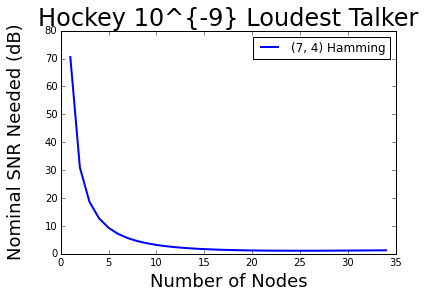

In [276]:
%%time
numwords = 3 # number of hamming code blocks stuck together
bpw = 21 # bits per word

target = 10**(-9)
# msgsize = 160
# blocklength = 10000
# rsblock = int(blocklength/bpw)
dSNR = 0.01
# dfade = [10**(-3), 10**(-10), 10**(-3)]
# end = 2
paddratio = 0.01

shannon = []

# fadexp = sp.stats.expon()

for N in range(1, 35):
    filename = 'shannon_tables/n' + str(N) + '.in' # sanity check
    codetable = load_table(filename)
#     func = interp1d(codetable[1], codetable[0], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))
    
    padd = paddratio*threshold
    actualSNR = codetable[0][np.where(codetable[1]<=padd)[0][0]]
#     actualSNR = func(padd) # in dB
    
#     rate = N * 160 / 10000
    
    
    SNR = 0
    pprotocol = 1.0
    while pprotocol > target:
        SNR += dSNR
        hcrit = 10**((actualSNR - SNR)/10) # linear fade
#         linSNR = 10**(SNR/10)
#         hcrit = (2**rate - 1)/linSNR
        pbadfade = 1 - exp(-hcrit)
        psingle = pbadfade + (1-pbadfade)*padd
        
        pprotocol = sum([nCr(N, a) * (1-psingle)**a * psingle**(N-a) * (1-(1-(pbadfade**a + (1-pbadfade**a) * padd))**(N-a)) for a in range(N)])
    shannon.append(SNR)
#     print('Protocol', N, SNR, hcrit, pbadfade, psingle)
    
    
print('Occupy?', array(shannon))
# print('Occupy CoW', array(shannon))
plot(range(1, 35), array(shannon), lw=2.0, label='(7, 4) Hamming')
# plot(range(1, 35), shannon, lw=2.0, label='Occupy CoW')
legend(loc=0)
xlabel('Number of Nodes', fontsize=18)
ylabel('Nominal SNR Needed (dB)', fontsize=18, labelpad=20)
title('Hockey 10^{-9} Loudest Talker', fontsize=24)
# savefig('LoudestTalkerShannon.pdf', bbox='tight')

[70.47399999997246, 30.894000000014778, 18.624999999999783, 12.712999999998397, 9.293000000000292, 7.106000000000711, 5.614000000000213, 4.548999999999857, 3.7629999999997006, 3.167999999999766, 2.7089999999998167, 2.350999999999856, 2.0679999999998873, 1.8419999999999122, 1.661999999999932, 1.5179999999999478, 1.4039999999999604, 1.3119999999999705, 1.2409999999999783, 1.1849999999999845, 1.143999999999989, 1.1129999999999924, 1.0929999999999946, 1.080999999999996, 1.0759999999999965, 1.0779999999999963, 1.0849999999999955, 1.0969999999999942, 1.1119999999999925, 1.1319999999999903, 1.1549999999999878, 1.179999999999985, 1.207999999999982, 1.2379999999999787]
[ 0.466  0.006  0.015  0.007  0.017  0.014  0.026  0.021  0.037  0.042
  0.051  0.049  0.052  0.068  0.068  0.082  0.086  0.098  0.109  0.125
  0.126  0.137  0.157  0.169  0.184  0.202  0.205  0.233  0.258  0.278
  0.315  0.34   0.392  0.442]


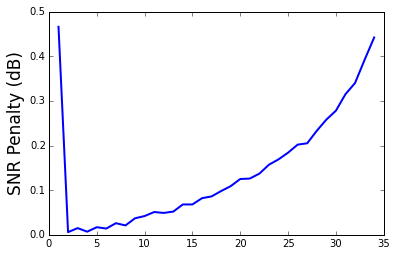

In [280]:
print(nomSNR)
plot(range(1, 35), array(shannon)-nomSNR, lw=2.0)
ylabel('SNR Penalty (dB)', fontsize=17)
print(array(shannon)-nomSNR)

('Actual SNR', array(0.8699999991662624))
('Hack Actual SNR', -7.4199999999980335)


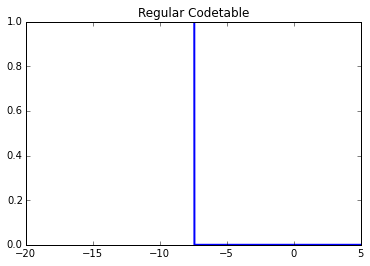

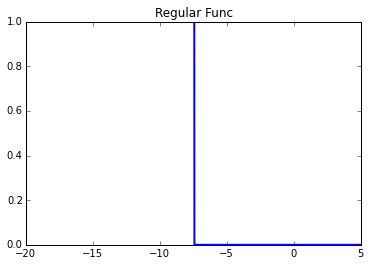

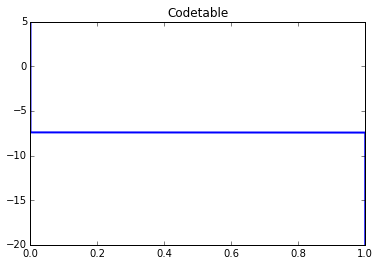

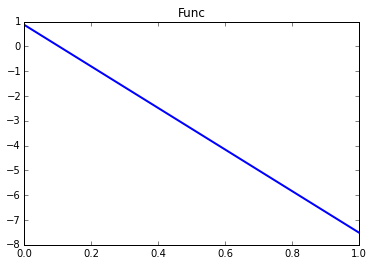

In [270]:
N = 15
SNR = 2.5
filename = 'shannon_tables/n' + str(N) + '.in' # sanity check
codetable = load_table(filename)
x, y = codetable[0], codetable[1]
func2 = interp1d(x, y, kind='linear', bounds_error=False, fill_value=(1.0, 0.0))

plot(x, y, lw=2.0)
title('Regular Codetable')

figure()
plot(x, func2(x), lw=2.0)
title('Regular Func')

figure()
plot(y, x, lw=2.0)
title('Codetable')

xreversed = x # x[::-1]
yreversed = y # y[::-1]
func = interp1d(yreversed, xreversed, kind='linear') #, bounds_error=False, fill_value=(codetable[1][0], codetable[1][-1]))

figure()
plot(yreversed, func(yreversed), lw=2.0)
title('Func')

padd = 0.1*threshold
actualSNR = func(padd) # in dB
print('Actual SNR', actualSNR)
hackactualSNR = x[np.where(y<=padd)[0][0]]
print('Hack Actual SNR', hackactualSNR)
# hcrit = 10**((actualSNR - SNR)/10) # linear fade
# print('Hcrit', hcrit)
# pbadfade = 1 - exp(-hcrit)
# print('Badfade', pbadfade)
# psingle = pbadfade + (1-pbadfade)*padd
# print('P(single)', psingle)
# pprotocol = sum([nCr(N, a) * (1-psingle)**a * psingle**(N-a) * (1-(1-(pbadfade**a + (1-pbadfade**a) * padd))**(N-a)) for a in range(N)])
# print('Protocol', pprotocol)

In [267]:
print(yreversed[::100])
print(xreversed[::100])
print(func(yreversed)[::100])
# codetable[0][-100]
print(func(0))
print(x[np.where(y<=padd)[0][0]])

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.]
[ -2.00000000e+01  -1.90000000e+01  -1.80000000e+01  -1.70000000e+01
  -1.60000000e+01  -1.50000000e+01  -1.40000000e+01  -1.30000000e+01
  -1.20000000e+01  -1.10000000e+01  -1.00000000e+01  -9.00000000e+00
  -8.00000000e+00  -7.00000000e+00  -6.00000000e+00  -5.00000000e+00
  -4.00000000e+00  -3.00000000e+00  -2.00000000e+00  -1.00000000e+00
   3.12638804e-12   1.00000000e+00   2.00000000e+00   3.00000000e+00
   4.00000000e+00]
[-7.51 -7.51 -7.51 -7.51 -7.51 -7.51 -7.51 -7.51 -7.51 -7.51 -7.51 -7.51
 -7.51  0.87  0.87  0.87  0.87  0.87  0.87  0.87  0.87  0.87  0.87  0.87
  0.87]
0.870000000003
-7.42


In [297]:
filename = 'lookup_0-01' + '/n' + str(1) + '.in'
codetable = load_table(filename)
print(np.where(array(codetable[1]) <= 0.5))
# codetable[0][np.where(codetable[1]<=padd)[0][0]]
# print(codetable[1][-10:])
print(type(codetable[1][500]))
print(codetable[1][500])
print(codetable[1][500] <= 0.5)
print(codetable[1] < 0.01)

(array([ 342,  343,  344, ..., 1497, 1498, 1499]),)
<type 'numpy.float64'>
5.53078576302e-24
True
False


# Uplink

In [383]:
def uplink(codingscheme, dSNR, target, paddratio, start_SNR, start_nodes, end_nodes):
    nomSNR = []

    for N in range(start_nodes, end_nodes):
        filename = codingscheme + '/n' + str(N) + '.in'
        codetable = load_table(filename)

        padd = paddratio*threshold
        actualSNR = codetable[0][np.where(array(codetable[1])<=padd)[0][0]]

        SNR = start_SNR
        pprotocol = 1.0
        while pprotocol > target:
            SNR += dSNR
            hcrit = 10**((actualSNR - SNR)/10) # linear fade
            pbadfade = 1 - exp(-hcrit)
            psingle = pbadfade + (1-pbadfade)*padd

            psuccess = sum([nCr(N, a) * (1-psingle)**a * psingle**(N-a) *
                ((1-(pbadfade**a + (1-pbadfade**a)*padd)**a)*(1-padd))**(N-a) for a in range(1,N+1)])
            pprotocol = 1 - psuccess
        nomSNR.append(SNR)
        print('Protocol', N, SNR, actualSNR)

    plot(range(start_nodes, end_nodes), array(nomSNR), lw=2.0, label=codingscheme)
    legend(loc=0)
    xlabel('Number of Nodes', fontsize=18)
    ylabel('Nominal SNR Needed (dB)', fontsize=18, labelpad=20)
    title('Hockey 10^{-9} Uplink', fontsize=24)
    
    return array(nomSNR)

In [349]:
# Test
N = 30
dSNR = 0.01
target = 10**(-9)
paddratio = 0.1 # padd = 10**(-10)

filename = 'shannon_tables' + '/n' + str(N) + '.in'
codetable = load_table(filename)

padd = paddratio*threshold
actualSNR = codetable[0][np.where(array(codetable[1])<=padd)[0][0]]

for SNR in [5, 10, 30, 50, 100]:
    hcrit = 10**((actualSNR - SNR)/10) # linear fade
    pbadfade = 1 - exp(-hcrit)
    psingle = pbadfade + (1-pbadfade)*padd

#     ptest = N * (1-psingle) * (psingle*(1-(pbadfade + (1-pbadfade)*padd))*(1-padd))**(N-1) # a = 1
    psuccess = sum([nCr(N, a) * (1-psingle)**a * psingle**(N-a) *
                ((1-(pbadfade**a + (1-pbadfade**a)*padd)**a)*(1-padd))**(N-a) for a in range(1,N+1)])
    pprotocol = 1 - psuccess
    print('SNR', SNR, 'pbadfade', pbadfade, 'ptest', ptest, 'psingle', psingle, 'pprotocol', pprotocol)


('SNR', 5, 'pbadfade', 0.11752595645588904, 'ptest', 7.6218342877488967e-28, 'psingle', 0.11752595654413645, 'pprotocol', 3.52577855800007e-10)
('SNR', 10, 'pbadfade', 0.038765287449010866, 'ptest', 1.0637802187899376e-40, 'psingle', 0.038765287545134336, 'pprotocol', 1.1629497365106545e-10)
('SNR', 30, 'pbadfade', 0.00039528847298553327, 'ptest', 6.0601534691124183e-98, 'psingle', 0.00039528857294600443, 'pprotocol', 1.1862733018119798e-12)
('SNR', 50, 'pbadfade', 3.9536583849031359e-06, 'ptest', 6.1711114784795068e-156, 'psingle', 3.95375838450777e-06, 'pprotocol', 1.0658141036401503e-14)
('SNR', 100, 'pbadfade', 3.9536707241438762e-11, 'ptest', 4.7107156727041059e-285, 'psingle', 1.3953670723748511e-10, 'pprotocol', 2.2204460492503131e-16)


('Protocol', 1, 70.93999999999939, -19.519999999999925)
('Protocol', 2, 30.900000000002034, -16.489999999999451)
('Protocol', 3, 18.120000000000037, -14.699999999999172)
('Protocol', 4, 11.849999999999794, -13.429999999998973)
('Protocol', 5, 8.189999999999872, -12.429999999998817)
('Protocol', 6, 5.799999999999922, -11.61999999999869)
('Protocol', 7, 4.159999999999957, -10.919999999998581)
('Protocol', 8, 2.949999999999982, -10.319999999998487)
('Protocol', 9, 2.050000000000001, -9.7799999999984024)
('Protocol', 10, 1.3600000000000017, -9.2999999999983274)
('Protocol', 11, 0.8100000000000013, -8.8599999999982586)
('Protocol', 12, 0.38000000000000095, -8.4599999999981961)
('Protocol', 13, 0.04000000000000076, -8.0899999999981382)
('Protocol', 14, -0.2199999999999993, -7.7399999999980835)
('Protocol', 15, -0.4299999999999995, -7.4199999999980335)
('Protocol', 16, -0.5899999999999996, -7.109999999997985)
('Protocol', 17, -0.7099999999999997, -6.8299999999979413)
('Protocol', 18, -0.78999

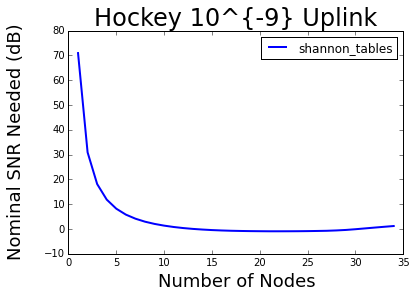

In [384]:
codingscheme = 'shannon_tables'
dSNR = 0.01
target = 10**(-9)
paddratio = 0.1 # padd = 10**(-10)
start_SNR = -1
start_nodes, end_nodes = 1, 35

shannonup = uplink(codingscheme, dSNR, target, paddratio, start_SNR, start_nodes, end_nodes)
print('Shannon', shannonup)

('Protocol', 1, 72.9100000000004, -17.549999999999617)
('Protocol', 2, 32.890000000002026, -14.49999999999914)
('Protocol', 3, 20.110000000000348, -12.70999999999886)
('Protocol', 4, 13.85999999999975, -11.419999999998659)
('Protocol', 5, 10.199999999999829, -10.419999999998502)
('Protocol', 6, 7.829999999999878, -9.5899999999983727)
('Protocol', 7, 6.199999999999913, -8.8799999999982617)
('Protocol', 8, 5.0099999999999385, -8.2599999999981648)
('Protocol', 9, 4.1199999999999575, -7.7099999999980788)
('Protocol', 10, 3.4399999999999715, -7.2199999999980022)
('Protocol', 11, 2.909999999999983, -6.7599999999979303)
('Protocol', 12, 2.4999999999999916, -6.3399999999978647)
('Protocol', 13, 2.1799999999999984, -5.9499999999978037)
('Protocol', 14, 1.9300000000000022, -5.5899999999977474)
('Protocol', 15, 1.740000000000002, -5.2499999999976943)
('Protocol', 16, 1.6000000000000019, -4.9199999999976427)
('Protocol', 17, 1.5000000000000018, -4.6199999999975958)
('Protocol', 18, 1.4400000000000

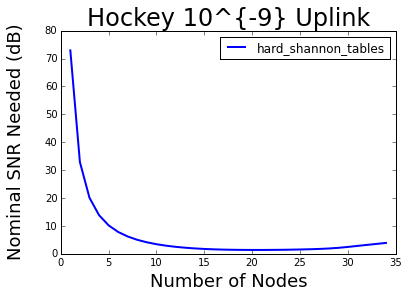

In [385]:
codingscheme = 'hard_shannon_tables'
dSNR = 0.01
target = 10**(-9)
paddratio = 0.1 # padd = 10**(-10)
start_SNR = -1
start_nodes, end_nodes = 1, 35

hardshannonup = uplink(codingscheme, dSNR, target, paddratio, start_SNR, start_nodes, end_nodes)
print('Hard Binary Shannon', hardshannonup)

('Protocol', 1, 89.90000000000909, -0.56000000000009464)
('Protocol', 2, 47.32999999999915, -0.060000000000105302)
('Protocol', 3, 33.16000000000197, 0.33999999999988617)
('Protocol', 4, 25.990000000001267, 0.70999999999987828)
('Protocol', 5, 21.65000000000059, 1.0299999999998715)
('Protocol', 6, 18.750000000000135, 1.3299999999998651)
('Protocol', 7, 16.629999999999804, 1.5499999999998604)
('Protocol', 8, 15.169999999999723, 1.8999999999998529)
('Protocol', 9, 13.939999999999749, 2.1099999999998484)
('Protocol', 10, 13.099999999999767, 2.4399999999998414)
('Protocol', 11, 12.349999999999783, 2.6799999999998363)
('Protocol', 12, 11.819999999999794, 2.9799999999998299)
('Protocol', 13, 11.239999999999807, 3.1099999999998271)
('Protocol', 14, 10.819999999999816, 3.2999999999998231)
('Protocol', 15, 10.789999999999816, 3.7999999999998124)
('Protocol', 16, 10.249999999999828, 3.7299999999998139)
('Protocol', 17, 10.16999999999983, 4.0499999999998071)
('Protocol', 18, 10.14999999999983, 4.

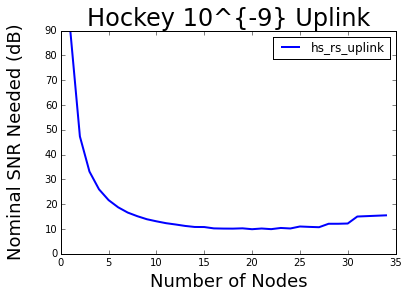

In [386]:
codingscheme = 'hs_rs_uplink'
dSNR = 0.01
target = 10**(-9)
paddratio = 0.1 # padd = 10**(-10)
start_SNR = -1
start_nodes, end_nodes = 1, 35

hammingup = uplink(codingscheme, dSNR, target, paddratio, start_SNR, start_nodes, end_nodes)
print('Hamming+RS', hammingup)

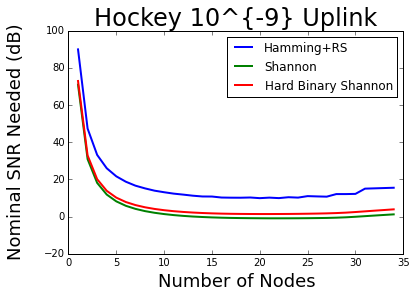

In [416]:
plot(range(start_nodes, end_nodes), hammingup, lw=2.0, label='Hamming+RS')
plot(range(start_nodes, end_nodes), shannonup, lw=2.0, label='Shannon')
plot(range(start_nodes, end_nodes), hardshannonup, lw=2.0, label='Hard Binary Shannon')
legend(loc=0)
xlabel('Number of Nodes', fontsize=18)
ylabel('Nominal SNR Needed (dB)', fontsize=18, labelpad=20)
title('Hockey 10^{-9} Uplink', fontsize=24)
savefig('hockey_uplink.pdf', bbox='tight')

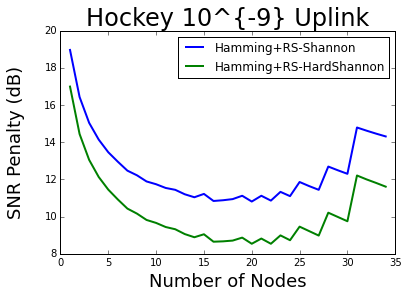

In [417]:
plot(range(start_nodes, end_nodes), hammingup-shannonup, lw=2.0, label='Hamming+RS-Shannon')
plot(range(start_nodes, end_nodes), hammingup-hardshannonup, lw=2.0, label='Hamming+RS-HardShannon')
legend(loc=0)
xlabel('Number of Nodes', fontsize=18)
ylabel('SNR Penalty (dB)', fontsize=18, labelpad=20)
title('Hockey 10^{-9} Uplink', fontsize=24)
savefig('penalty_uplink.pdf', bbox='tight')

In [368]:
op_SNR = arange(-5, 15, 0.01)
num_nodes = arange(1, 36)
for n in num_nodes:
    blocklength = int(10000/21/n)
    filename = 'hs_rs_uplink/n' + str(n) + '.in'
    rate = n*160/10000
    table = hs_rs_table(op_SNR, rate, blocklength)
    save_table(table, filename)

[  8.93120221e-01   9.68136274e-01   9.94827434e-01   9.99603127e-01
   9.98830121e-01   9.83303051e-01   8.90105887e-01   6.42775260e-01
   3.29094714e-01   1.15687713e-01   2.80701797e-02   4.62401570e-03
   4.87590826e-04   2.98296695e-05   9.26013183e-07   1.22792855e-08
   5.59116087e-11   7.79376563e-14   1.29896094e-14   0.00000000e+00]


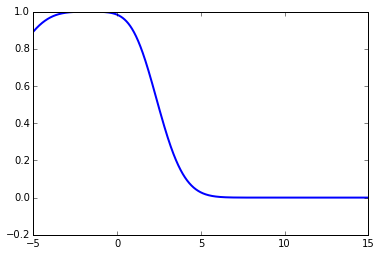

In [376]:
filename = 'hs_rs_uplink/n' + str(35) + '.in'
codetable = load_table(filename)
plot(codetable[0], codetable[1], lw=2.0)
print(codetable[1][::100])
# codetable[0][np.where(array(codetable[1])<=padd)[0][0]]

('Rate', 0.9800000000000001, 'Blocklength', 476, 'Parity', 9.519999999999955)


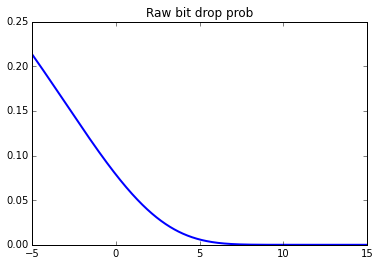

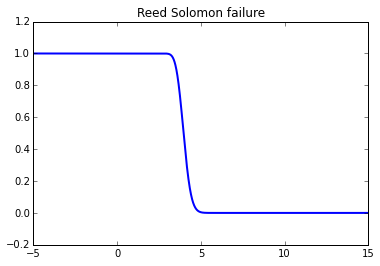

In [388]:
# Not Uplink, Larger blocklength
op_SNR = arange(-5, 15, 0.01)
rate = 35*160/10000
blocklength = int(10000/21)
rate = rate * 7/4
k = (1-rate)*blocklength
print('Rate', rate, 'Blocklength', blocklength, 'Parity', k)
msg = rate*blocklength
#     op_SNR = arange(-5, 10, 0.01)
pbitdrop = Q(sqrt(2*10**(op_SNR/10)))
#     pbitdrop = array([0.5*math.erfc(sqrt(10**(opsnr/10)/2)) for opsnr in op_SNR])
plot(op_SNR, pbitdrop, lw=2.0)
title('Raw bit drop prob')
hcerr = 1 - ((1-pbitdrop)**7 + 7*pbitdrop*(1-pbitdrop)**6)
hcflst = 1 - (1-hcerr)**3
reeddrop = [sum([nCr(blocklength, d)* hcf**d *(1-hcf)**(blocklength-d) for d in range(int(k/2)+1, blocklength)]) \
            for hcf in hcflst]
figure()
plot(op_SNR, array(reeddrop), lw=2.0)
title('Reed Solomon failure')

('Rate', 0.9800000000000001, 'Blocklength', 13, 'Parity', 0.2599999999999988)
(0.2132280183576204, 0.45936048972966348, 0.84197589361708181, 0.89312022083555753)
(0.18611381748338962, 0.38476950343615779, 0.76712998827678769, 0.96813627356957022)


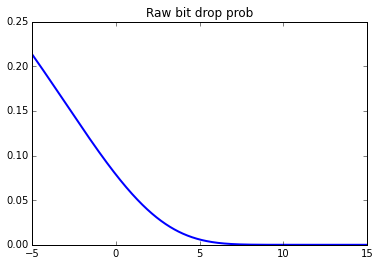

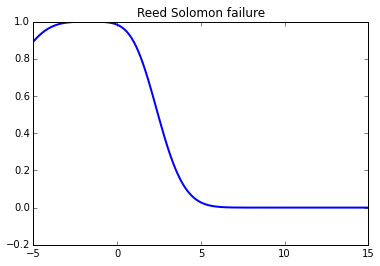

In [393]:
# Uplink, small blocklength
op_SNR = arange(-5, 15, 0.01)
rate = 35*160/10000
blocklength = int(10000/21/35)
rate = rate * 7/4
k = (1-rate)*blocklength
print('Rate', rate, 'Blocklength', blocklength, 'Parity', k)
msg = rate*blocklength
#     op_SNR = arange(-5, 10, 0.01)
pbitdrop = Q(sqrt(2*10**(op_SNR/10)))
#     pbitdrop = array([0.5*math.erfc(sqrt(10**(opsnr/10)/2)) for opsnr in op_SNR])
plot(op_SNR, pbitdrop, lw=2.0)
title('Raw bit drop prob')
hcerr = 1 - ((1-pbitdrop)**7 + 7*pbitdrop*(1-pbitdrop)**6)
hcflst = 1 - (1-hcerr)**3
reeddrop = [sum([nCr(blocklength, d)* hcf**d *(1-hcf)**(blocklength-d) for d in range(int(k/2)+1, blocklength)]) \
            for hcf in hcflst]
figure()
plot(op_SNR, array(reeddrop), lw=2.0)
title('Reed Solomon failure')

print(pbitdrop[0], hcerr[0], hcflst[0], reeddrop[0])
print(pbitdrop[100], hcerr[100], hcflst[100], reeddrop[100])

Uplink waterfall plot goes up initially because low SNR ==> high probability of bit drop (very right mean of binomial distribution), combined with low blocklength (can't quite access law of large numbers) ==> integrals of the waterfall (pr codeword failure) don't quite capture the entire binomial. The entire right tail is missing!

Thankfully, at higher SNR the probability of bit drop decreases, so the mean of the binomial moves left, so we start integrating over the entire binomial (eventually we might start cutting out the left tail.)

Hockey plots only care about low probability of failure, which only happens at high SNRs, so the glitch/anomaly doesn't impact us.

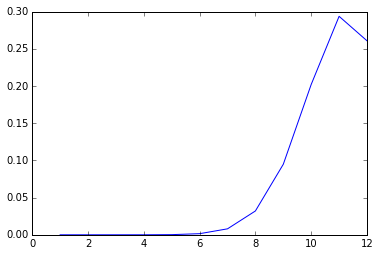

In [413]:
blocklength = 13
hcf0 = hcflst[0]
test = [nCr(blocklength, d)* hcf0**d *(1-hcf0)**(blocklength-d) for d in range(int(k/2)+1, blocklength)]
plot(range(int(k/2)+1, blocklength), test)

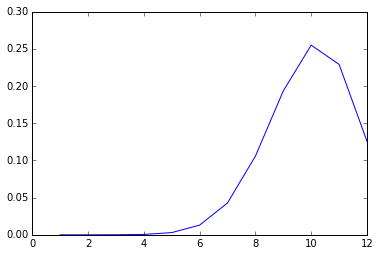

In [414]:
hcf100 = hcflst[100]
test = [nCr(blocklength, d)* hcf100**d *(1-hcf100)**(blocklength-d) for d in range(int(k/2)+1, blocklength)]
plot(range(int(k/2)+1, blocklength), test)

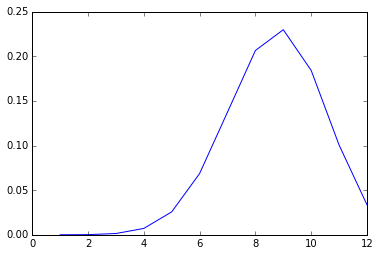

In [415]:
hcf200 = hcflst[200]
test = [nCr(blocklength, d)* hcf200**d *(1-hcf200)**(blocklength-d) for d in range(int(k/2)+1, blocklength)]
plot(range(int(k/2)+1, blocklength), test)